## Diagnóstico de Cáncer de Mama ##

### Importamos las librerías necesarias

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import diagnostico_cancer.src.preprocessing as pr
import diagnostico_cancer.src.data_splitting as ds
from diagnostico_cancer.src.models import LinearRegression, BinaryClassifier
import diagnostico_cancer.src.metrics as metrics

### Hacemos un análisis exploratorio de los datos

In [2]:
path1 = 'diagnostico_cancer/data/raw/cell_diagnosis_dev.csv'
cancer_dataset = pd.read_csv(path1)

          CellSize    CellShape  NucleusDensity  ChromatinTexture  \
count  1333.000000  1347.000000     1362.000000       1366.000000   
mean     83.247087     0.598657        2.097344         26.094973   
std     100.316719     0.565438        4.987573         24.842157   
min    -100.000000    -1.413038       -3.000000         10.000000   
25%      66.572149     0.479758        1.397010         21.279126   
50%      69.704323     0.498832        1.445035         22.066810   
75%      72.653147     0.523018        1.485651         22.823319   
max    1000.000000     5.048566       50.000000        263.793425   

       CytoplasmSize  CellAdhesion  MitosisRate  NuclearMembrane  \
count    1347.000000   1369.000000  1343.000000      1343.000000   
mean       33.989815      0.548800     5.326484         2.825365   
std        32.809627      0.612232    11.572456         2.697956   
min         5.000000     -4.461755   -50.000000        -3.438990   
25%        26.304514      0.456400    

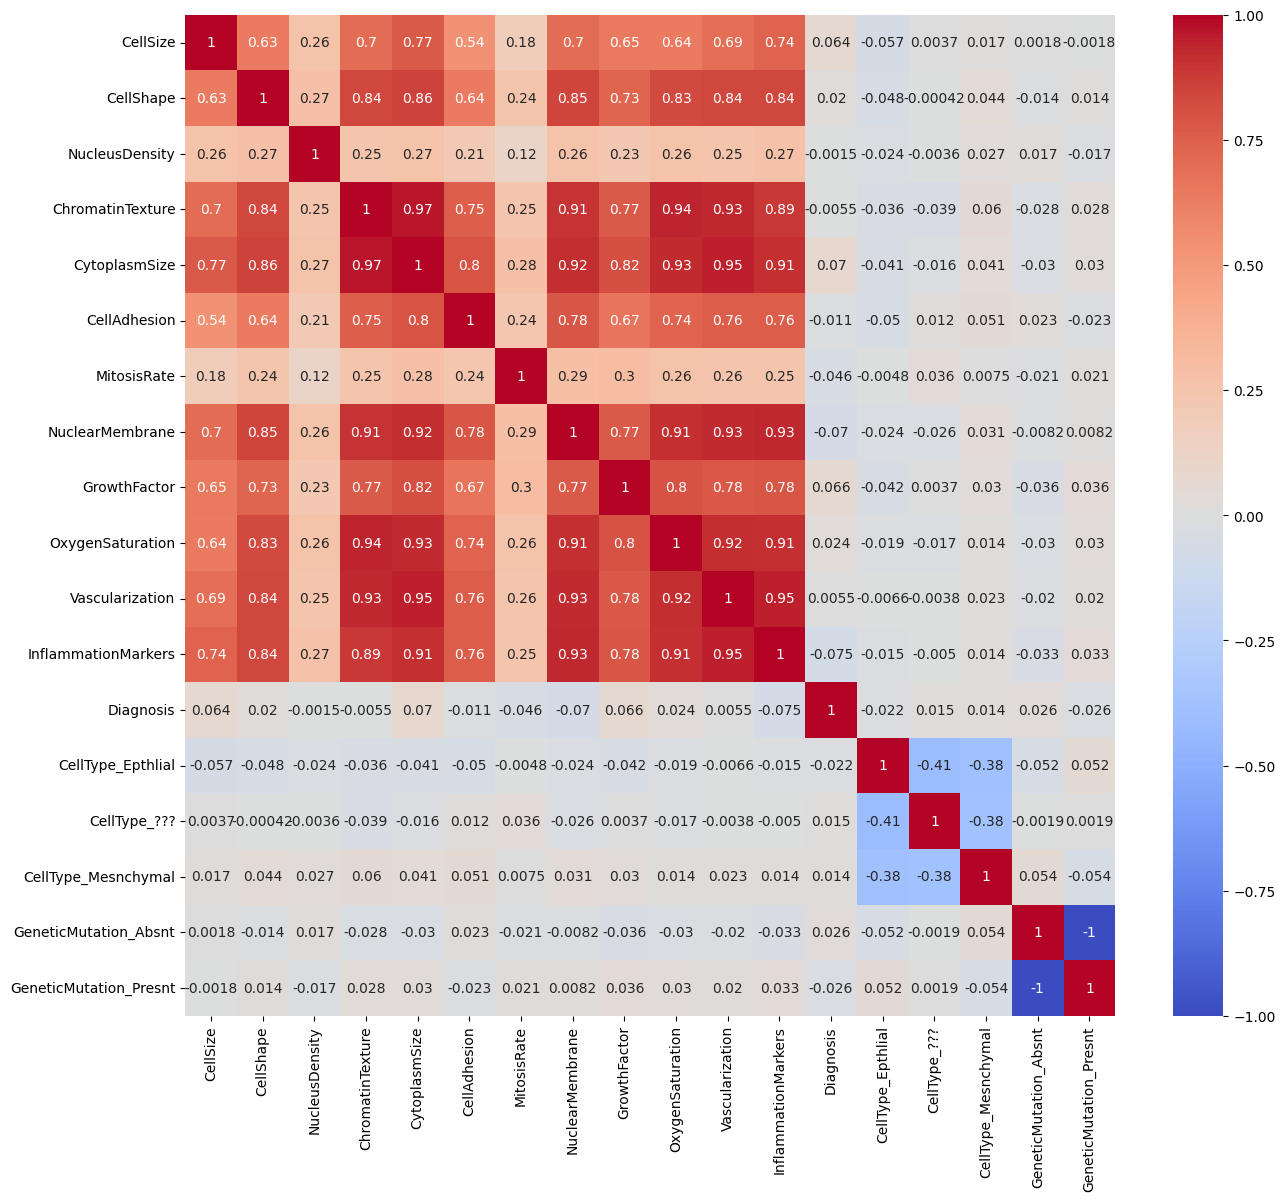

In [3]:
# PREGUNTAS
# 1) VER SI ES VALIDO REMOVER LOS OUTLIERS
print(cancer_dataset.describe()) # Resumen estadístico de los datos
print(cancer_dataset.isnull().sum()) # Cantidad de valores faltantes por columna

pr.corr_matrix(cancer_dataset, categorical_columns=['CellType', 'GeneticMutation'])

### Limpiamos el dataset

In [4]:
cancer_dataset = pr.remove_missing_rows(cancer_dataset, threshold=35) # Remuevo las filas que tienen más de 35% nans

numeric_cols = [
    'CellSize', 'CellShape', 'NucleusDensity', 'ChromatinTexture',
    'CytoplasmSize', 'CellAdhesion', 'MitosisRate', 'NuclearMembrane',
    'GrowthFactor', 'OxygenSaturation', 'Vascularization', 'InflammationMarkers'
]

categorical_cols = [
    'CellType', 'GeneticMutation'
]

cols_range = {
    'CellSize': (0, np.inf) , 'NucleusDensity': (0, np.inf), 'CellAdhesion': (0, 1), 
    'MitosisRate': (0, np.inf), 'NuclearMembrane': (1, 5), 'OxygenSaturation': (0, 100), 
    'Vascularization': (0, 10), 'InflammationMarkers': (0, 100)
}

cancer_dataset = pr.replace_outliers(cancer_dataset, 'CellSize') # remover otros outliers

cancer_dataset = pr.set_range(cancer_dataset, range=cols_range)

cancer_dataset[numeric_cols] = pr.KNN(cancer_dataset, numeric_cols, k=5)

cancer_dataset = pr.replace_missing_values(cancer_dataset, columns=categorical_cols, keywords=['???'])

cancer_dataset = pr.knn_impute_celltype(cancer_dataset, numeric_cols, k=5)

cancer_dataset = pr.one_hot_encoder(cancer_dataset, columns=categorical_cols)
print(cancer_dataset.head(20))

Removed 39 rows with more than 35% NaNs.
Number of outliers replaced in column [CellSize]: 87
     CellSize  CellShape  NucleusDensity  ChromatinTexture  CytoplasmSize  \
0   63.423148   0.500594        1.473261         23.300222      25.759917   
1   72.906362   0.474808        1.361360         21.336137      29.856233   
2   70.711969   0.481701        1.378887         21.521406      30.582427   
3   73.210206   0.490835        1.427612         22.437077      29.887970   
4   68.348288   0.504773        1.454116         21.150723      28.328197   
5   63.467884   0.494407        1.498820         22.676137      25.726299   
7   69.122817   2.849222        7.382190        229.184799     271.103974   
8   69.595755   0.538546        1.362151         21.314999      28.983911   
9   64.818977   0.499523        1.517036         21.567709      25.765601   
10  73.473872   0.496329        1.419658         21.442583      31.940005   
11  65.586021   0.533950        1.454234         22.465941 

### Entrenamos el modelo

#### Buscamos el mejor parámetro de regularización

In [5]:
columns_to_normalize = [
    'CellSize', 'CellShape', 'NucleusDensity', 'ChromatinTexture',
    'CytoplasmSize', 'MitosisRate', 'NuclearMembrane',
    'GrowthFactor', 'OxygenSaturation', 'Vascularization', 'InflammationMarkers'
]

train_df, valid_df = ds.train_val_split(cancer_dataset, seed=42, train_size=0.8)
train_df, valid_df = pr.normalize_train_test(train_df, valid_df, columns=columns_to_normalize)

possible_lambdas = np.logspace(-3, 1, 5).tolist()
avg_lambdas = ds.cross_val(valid_df, target_name='Diagnosis', lambda_values=possible_lambdas, k = 5)



/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/numpy/core/fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
Cross-validation folds: 100%|██████████| 5/5 [00:51<00:00, 10.33s/it]

F-scores for each fold and lambda value:
     0.001     0.010     0.100     1.000     10.000
1  0.800000  0.800000  0.800000  0.697674  0.206897
2  0.881356  0.881356  0.881356  0.842105  0.181818
3  0.754717  0.754717  0.754717  0.705882  0.421053
4  0.800000  0.800000  0.800000  0.750000  0.400000
5  0.806452  0.806452  0.786885  0.750000  0.342857
Average F-scores for each lambda value
Lambda 0.001: F-score = 0.8085
Lambda 0.01: F-score = 0.8085
Lambda 0.1: F-score = 0.8046
Lambda 1.0: F-score = 0.7491
Lambda 10.0: F-score = 0.3105


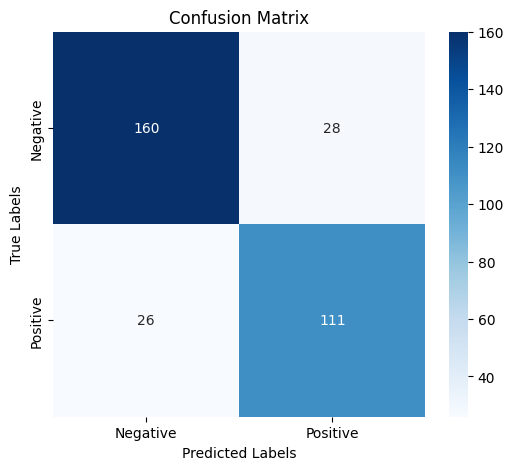

MODEL ACCURACY: 0.8338461538461538
MODEL PRECISION: 0.7985611510791367
MODEL RECALL: 0.8102189781021898
MODEL F-SCORE: 0.8043478260869565


In [7]:
model = BinaryClassifier(train_df, target_name='Diagnosis', ridge_lambda=0, fit=True) # con regularizacion empeora

# Generate predictions for the training data
valid_features = valid_df.drop(columns=['Diagnosis']).values
valid_predictions = model.predict(valid_features)

results = pd.DataFrame({
    'Diagnosis': valid_df['Diagnosis'],
    'Prediction': valid_predictions
})

model_stats = metrics.extract_results(results)

metrics.confusion_matrix(model_stats)

print(f'MODEL ACCURACY: {metrics.accuracy(model_stats)}')
print(f'MODEL PRECISION: {metrics.precision(model_stats)}')
print(f'MODEL RECALL: {metrics.recall(model_stats)}')
print(f'MODEL F-SCORE: {metrics.fscore(model_stats)}')

### Evalúo el modelo en el conjunto de test